In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import preprocessing

Text(0.5, 1.0, 'Mask')

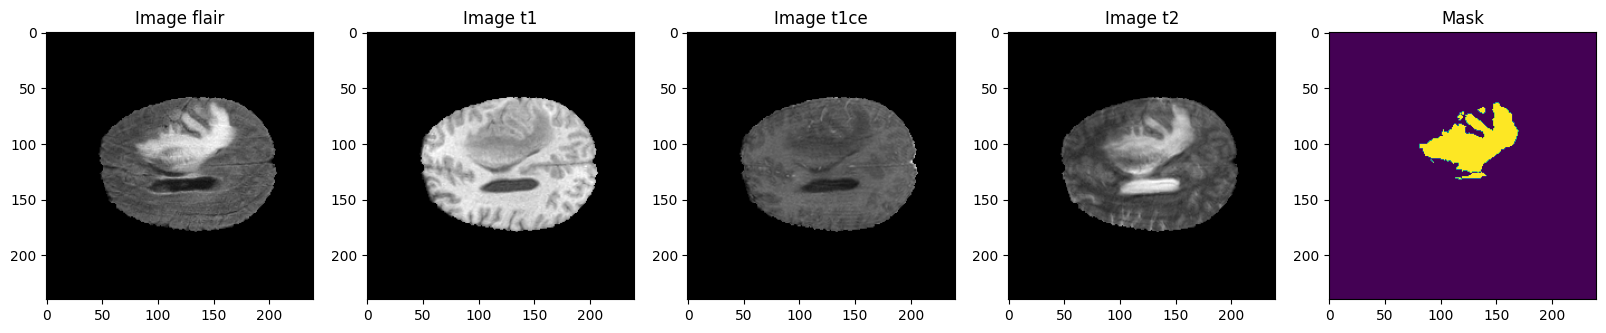

In [3]:
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


In [4]:
data_path = "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


In [5]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

In [6]:
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set 
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


In [17]:
VOLUME_START_AT = 60 
VOLUME_SLICES = 75 

In [ ]:
# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
IMG_SIZE = 128

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 8, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):
            
            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            #t1_path = sample_path + '_t1.nii'
            #t2_path = sample_path + '_t2.nii'
            
            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                    
        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y
        
training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)


In [ ]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

In [ ]:
import keras.backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[:,:,:,i], (-1,))
        y_pred_f = tf.reshape(y_pred[:,:,:,i], (-1,))
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss



def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())
    
def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())


In [56]:
import tensorflow

In [57]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

In [59]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                       patience=2, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
                                     verbose=1, save_best_only=True, save_weights_only=True, save_freq='epoch'),
    CSVLogger('training.log', separator=',', append=False)
]


In [64]:
model.fit(training_generator,
          epochs=1,
          steps_per_epoch=50,  # Update this parameter to 120
          callbacks=callbacks,
          validation_data=valid_generator)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9820 - dice_coef: 0.2755 - loss: 0.0766 - mean_io_u_8: 0.7092 - precision: 0.9831 - sensitivity: 0.9816 - specificity: 0.9944 
Epoch 1: val_loss improved from inf to 0.08098, saving model to model_.01-0.080979.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2047s 41s/step - accuracy: 0.9820 - dice_coef: 0.2755 - loss: 0.0768 - mean_io_u_8: 0.7082 - precision: 0.9831 - sensitivity: 0.9816 - specificity: 0.9944 - val_accuracy: 0.9802 - val_dice_coef: 0.2806 - val_loss: 0.0810 - val_mean_io_u_8: 0.4241 - val_precision: 0.9813 - val_sensitivity: 0.9777 - val_specificity: 0.9938 - learning_rate: 0.0010


In [71]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [72]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [75]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'
            
    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    
    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
    # Send our images to the CNN model and return predicted segmentation 
    return model.predict(X/np.max(X), verbose=1)

In [76]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)
    
    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')
    
    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')
    
    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')
    
    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')
    
    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 942ms/step
Patient number:  BraTS20_Training_149


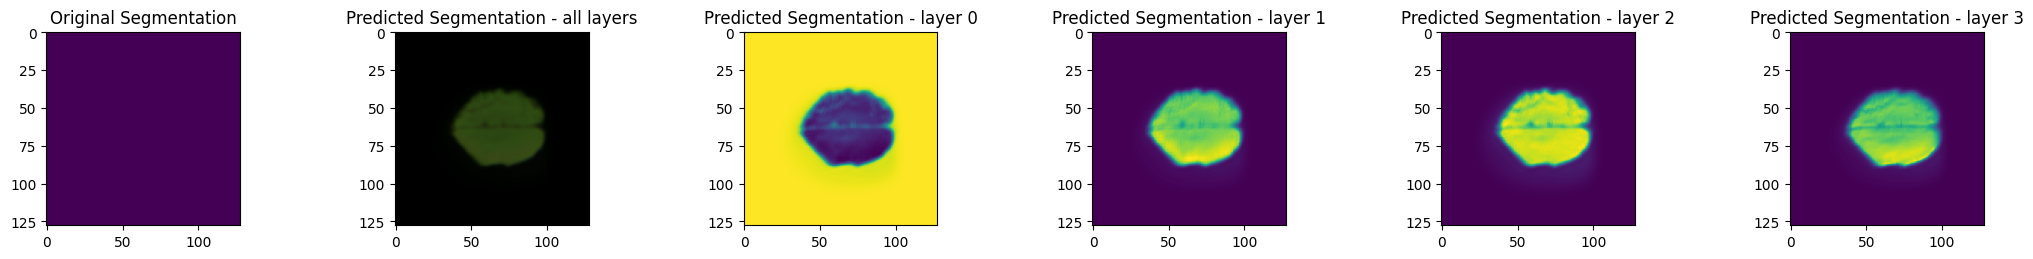

In [82]:
import matplotlib as mpl
import random
cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

show_predicted_segmentations(samples_test, 60, cmap, norm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 651ms/step
Patient number:  BraTS20_Training_114


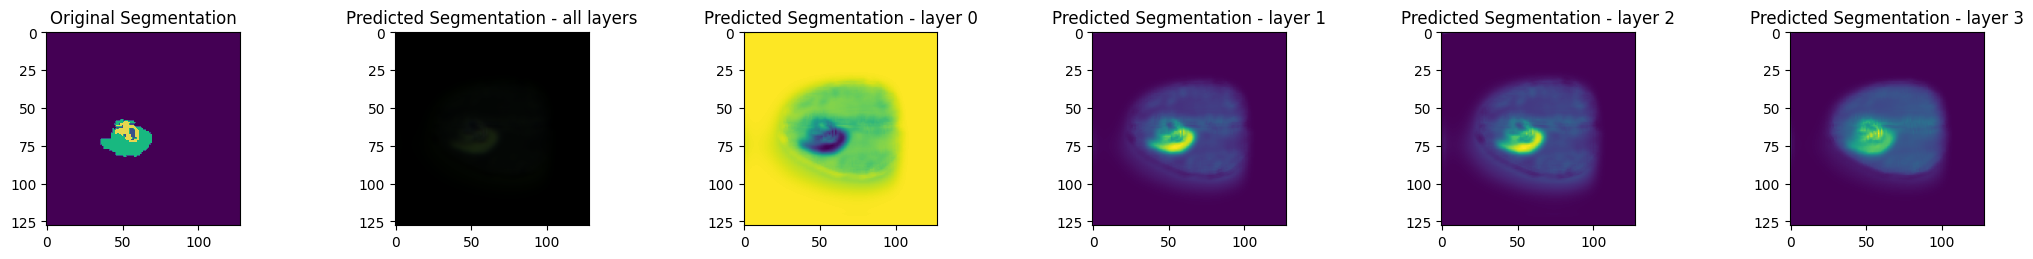

In [83]:
show_predicted_segmentations(samples_test, 50, cmap, norm)

In [ ]:
import tensorflow as tf

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,1])) + tf.reduce_sum(tf.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,2])) + tf.reduce_sum(tf.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(tf.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:,:,:,3])) + tf.reduce_sum(tf.square(y_pred[:,:,:,3])) + epsilon)

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data


C:\Users\Agilan M A\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/45 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.9792 - dice_coef: 0.2772 - dice_coef_edema: 0.1475 - dice_coef_enhancing: 0.0770 - dice_coef_necrotic: 0.0891 - loss: 0.0835 - mean_io_u_14: 0.4304 - precision: 0.9794 - sensitivity: 0.9790 - specificity: 0.9932